# Overfitting, Regularization, and Information Criteria

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import theano
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import statsmodels.formula.api as smf 
%matplotlib inline

In [3]:
sns.set()

## The Problem with Parameters

### 6.1

In [4]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = pd.DataFrame({"species": sppnames,
                  "brain": brainvolcc,
                  "mass": masskg})

### 6.2

In [5]:
m6_1 = smf.ols("brain ~ mass", data=d).fit()

### 6.3

In [6]:
1 - m6_1.resid.var()/d["brain"].var()

0.490158047949084

### 6.4

In [7]:
m6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

### 6.5

In [8]:
m6_3 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3)", data=d).fit()
m6_4 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)", data=d).fit()
m6_5 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d).fit()
m6_6 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)", data=d).fit()

### 6.6

In [9]:
m6_7 = smf.ols('brain ~ 1', data=d).fit()

### 6.7

In [10]:
d_new = d.drop(d.index[-1])

### 6.8

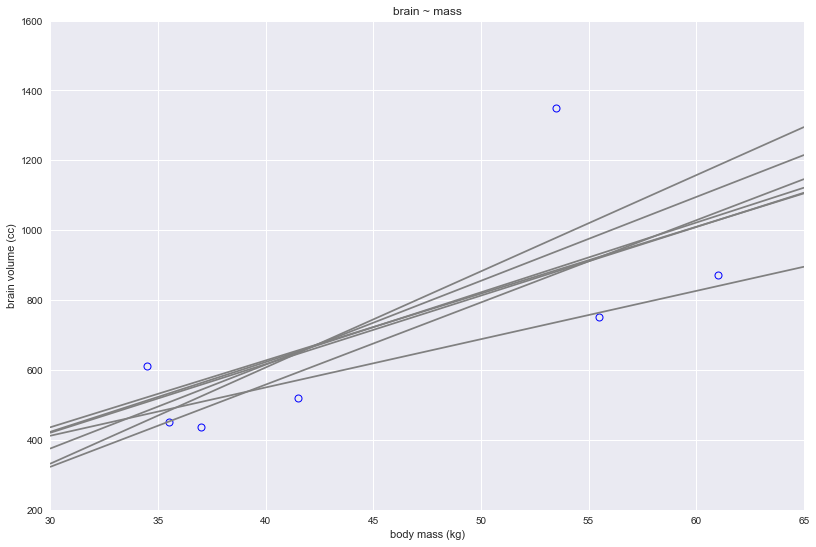

In [11]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
xs = pd.DataFrame({"mass": np.linspace(30, 65, 30)})

ax.plot(d["mass"], d["brain"], "o", mew=1.0, mec="b", mfc="None")
for i in range(len(d)):
    d_new = d.drop(d.index[i])
    m0 = smf.ols("brain ~ mass", data=d_new).fit()
    ax.plot(xs, m0.predict(xs), color="grey")

ax.set_xlim(30, 65)
ax.set_ylim(200, 1600)
ax.set_xlabel("body mass (kg)")
ax.set_ylabel("brain volume (cc)")
ax.set_title("brain ~ mass");

## Information Theory and Model Performance

### 6.9

In [12]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

### 6.10

In [13]:
m6_1 = smf.ols("brain ~ mass", data=d).fit()
-2 * m6_1.llf

94.92498968588757

### 6.11

In [14]:
d["mass_s"] = (d["mass"] - d["mass"].mean())/d["mass"].std()

with pm.Model() as m6_8:
    a = pm.Normal("a", mu=np.mean(d["brain"]), sd=10)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0, np.std(d["brain"]) * 10)
    mu = pm.Deterministic("mu", a + b * d["mass_s"])
    brain = pm.Normal("brain", mu=mu, sd=sigma, observed=d["brain"])
    trace6_8 = pm.sample(draws=1000, tune=1000)
    
theta = pm.summary(trace6_8, varnames=["a", "b", "sigma"])["mean"]
dev = -2 * np.sum(stats.norm.logpdf(d["brain"], loc=theta["a"] + theta["b"]*d["mass_s"], scale=theta["sigma"]))
dev

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1149.64draws/s]


100.15540030881115

### 6.12

Implementing [this](https://github.com/rmcelreath/rethinking/blob/a309712d904d1db7af1e08a76c521ab994006fd5/R/sim_train_test.R) function in python, but largely copying over from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb)

In [15]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.14], b_sigma=100):
    n_dim = 1 + len(rho)

    if n_dim < k:
        rho = np.pad(rho, (0, k - n_dim), "constant")
        n_dim = k
    
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:] = rho
    Rho[1:, 0] = rho
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
   
    mm_train = np.concatenate([np.ones((N, 1)), x_train[:, 1:k]], axis=1)
    mm_test = np.concatenate([np.ones((N, 1)), x_test[:, 1:k]], axis=1)

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(k), shape=(1, k))
        mu = pm.Deterministic('mu', pm.math.dot(mm_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
        tracem_sim = pm.sample()

    vec = np.array(pm.summary(tracem_sim)['mean'][:k]).reshape(k, -1)
    dev_train = -2 * sum(stats.norm.logpdf(x_train[:, 0], loc=np.matmul(mm_train, vec), scale=1))
    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))
    return np.mean(dev_train), np.mean(dev_test)

### 6.13

In [16]:
deviances = []
for k in range(1, 6):
    for _ in range(10):
        dev_train, dev_test = sim_train_test(k=k)
        deviances.append((k, dev_train, dev_test))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1035.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 664.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 643.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1195.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|█████████

Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 814.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 891.40draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 819.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 460.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 383.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sam

### 6.14

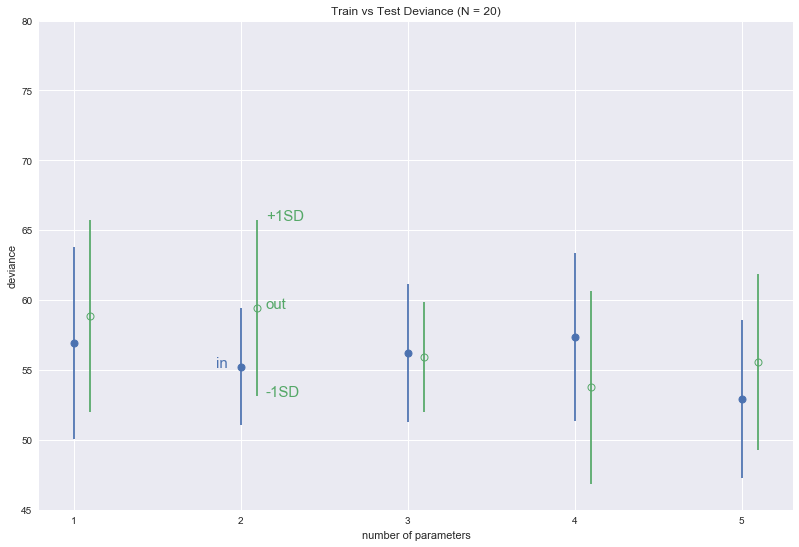

In [17]:
data = (pd.DataFrame(deviances, columns=["k", "dev_train", "dev_test"])
        .groupby("k")
        .agg({"dev_train": [np.mean, np.std],
              "dev_test": [np.mean, np.std]}))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=data.index, y=data["dev_train", "mean"], fmt="o", yerr=data["dev_train", "std"],
           mew=1.0, mec="C0");
ax.errorbar(x=data.index +0.1, y=data["dev_test", "mean"], fmt="o", yerr=data["dev_test", "std"],
           mew=1.0, mec="C1", mfc="None");
ax.set_xlabel("number of parameters")
ax.set_ylabel("deviance")
ax.set_title("Train vs Test Deviance (N = 20)")
plt.text(2 - 0.15, data.loc[2]["dev_train", "mean"], "in", color="C0", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"], "out", color="C1", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"] + data.loc[2]["dev_test", "std"],
         "+1SD", color="C1", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"] - data.loc[2]["dev_test", "std"],
         "-1SD", color="C1", fontsize=15)
ax.set_ylim(45, 80);

## Regularization

## Information Criteria

### 6.15

In [18]:
cars = pd.read_csv('Data/cars.csv', sep=',')

with pm.Model() as m6_9:
    sigma = pm.Uniform("sigma", 0, 30)
    b = pm.Normal("b", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + b*cars["speed"])
    dist = pm.Normal("dist", mu=mu, sd=sigma, observed = cars["dist"])
    trace6_9 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 787.24draws/s]


### 6.16

In [19]:
n_samples = 1000

acc = []
for _ in range(n_samples):
    mu = trace6_9["a"][0] + trace6_9["b"][0]*cars["speed"]
    sigma = trace6_9["sigma"][0]
    acc.append(stats.norm.logpdf(cars["dist"], loc=mu, scale=sigma))
ll = np.array(acc)

### 6.17

In [20]:
n_cases = len(cars)
lppd = logsumexp(ll, axis=0) - np.log(n_samples)

### 6.18

In [21]:
pWAIC = np.var(ll, axis=0)

### 6.19

In [22]:
-2 * (sum(lppd) - sum(pWAIC))

419.4253767961698

### 6.20

In [23]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

18.999131974221825

## Using Information Criteria

### 6.21

In [24]:
d = (pd.read_csv("Data/milk.csv", sep=";")
     .dropna())
d["neocortex"] = d["neocortex.perc"]/100
d.shape

(17, 9)

### 6.22

I'll be using the priors defined in [code block 14](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb)

In [25]:
a_start = d["kcal.per.g"].mean()
sigma_start = d["kcal.per.g"].std()

# Create shared variables that can be set later, used in 6.29
model_logmass = theano.shared(np.log(d['mass'].values))
model_neocortex = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    mu = pm.Deterministic("mu", a + 0*model_logmass) # Keep dimensions consistent
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_11 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6_12:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    bn = pm.Normal("bn", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bn*model_neocortex)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_12 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6_13:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    bm = pm.Normal("bm", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bm*model_logmass)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_13 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6_14:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    bn = pm.Normal("bn", mu=0, sd=10)
    bm = pm.Normal("bm", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bn*model_neocortex + bm*model_logmass)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_14 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1506.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bn, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 369.13draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6674098562430963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6598689914545506, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUT

### 6.23

In [26]:
pm.waic(trace6_14, m6_14)

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-17.134886447315974, WAIC_se=4.690058955173445, p_WAIC=2.8421428520569223, var_warn=1)

### 6.24

In [27]:
milk_models = (pm.compare({m6_11 : trace6_11,
                           m6_12 : trace6_12,
                           m6_13 : trace6_13,
                           m6_14 : trace6_14},
                          method='pseudo-BMA')
               .join(pd.Series(["m6_11", "m6_12", "m6_13", "m6_14"], name="model"))
               .set_index("model")
               .sort_values("WAIC"))
milk_models

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6_14,-17.13,2.84,0,0.96,4.69,0,1
m6_13,-8.83,2.08,8.31,0.02,4.16,3.19,1
m6_11,-8.71,1.38,8.43,0.01,3.66,4.53,0
m6_12,-7.39,1.92,9.75,0.01,3.27,4.76,0


### 6.25

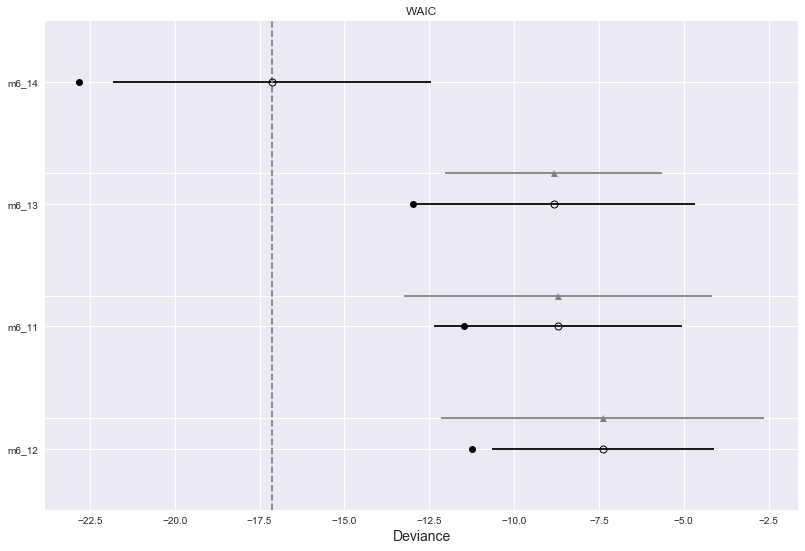

In [28]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
pm.compareplot(milk_models, ax=ax)
ax.set_title("WAIC");

### 6.26

In [29]:
diff = stats.norm.rvs(loc=milk_models.loc["m6_11", "dWAIC"], 
                      scale=milk_models.loc["m6_11", "dSE"], 
                      size=int(1e5))
sum(diff < 0)/1e5

0.03147

### 6.27

In [30]:
summaries = [("m6_11", pm.summary(trace6_11, alpha=0.11, varnames=["a", "sigma"])),
             ("m6_12", pm.summary(trace6_12, alpha=0.11, varnames=["a", "bn", "sigma"])),
             ("m6_13", pm.summary(trace6_13, alpha=0.11, varnames=["a", "bm", "sigma"])),
             ("m6_14", pm.summary(trace6_14, alpha=0.11, varnames=["a", "bn", "bm", "sigma"]))]

coeftab = (pd.concat([summary.reset_index().assign(model=model) for (model, summary) in summaries])
           .rename(columns={"index": "parameter"})
           .set_index(["parameter", "model"]))

(coeftab
 .reset_index()
 .pivot_table(index="parameter", columns="model", values="mean"))

model,m6_11,m6_12,m6_13,m6_14
parameter,,,,
a,0.658107,0.279871,0.703233,-1.055980
bm,NaN,NaN,-0.031027,-0.094950
bn,NaN,0.558850,NaN,2.746532
sigma,0.187116,0.189556,0.182121,0.141175


### 6.28

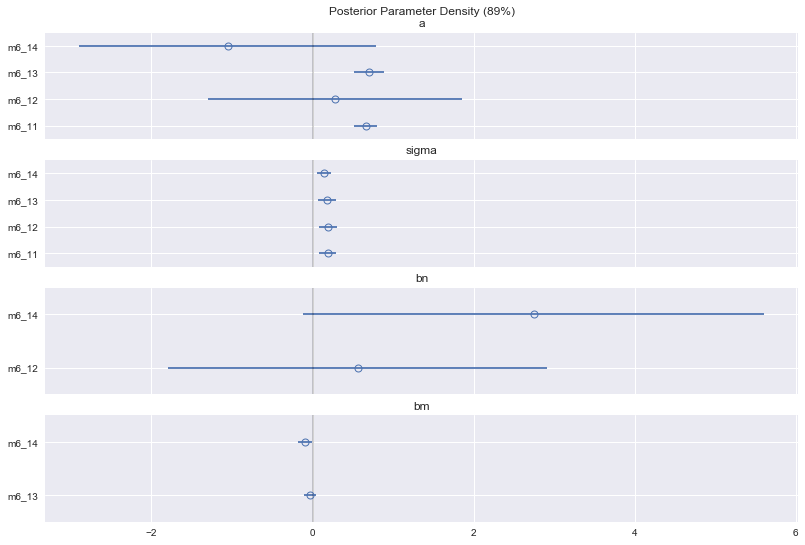

In [31]:
f, axs = plt.subplots(4, 1, sharex=True)
f.set_size_inches(13.5, 9)
data = (coeftab[["mean", "hpd_5.5", "hpd_94.5"]])

axs[0].errorbar(data.loc["a"]["mean"], data.loc["a"].index, fmt="o", 
                xerr=data.loc["a"]["hpd_94.5"] - data.loc["a"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[0].vlines(0, ymin=-1, ymax=4, alpha=0.2)
axs[0].set_ylim(-0.5, 3.5)
axs[0].set_title("Posterior Parameter Density (89%)\n"
                 "a")

axs[1].errorbar(data.loc["sigma"]["mean"], data.loc["sigma"].index, fmt="o", 
                xerr=data.loc["sigma"]["hpd_94.5"] - data.loc["sigma"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[1].vlines(0, ymin=-1, ymax=4, alpha=0.2)
axs[1].set_ylim(-0.5, 3.5)
axs[1].set_title("sigma")

axs[2].errorbar(data.loc["bn"]["mean"], data.loc["bn"].index, fmt="o", 
                xerr=data.loc["bn"]["hpd_94.5"] - data.loc["bn"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[2].vlines(0, ymin=-1, ymax=2, alpha=0.2)
axs[2].set_ylim(-0.5, 1.5)
axs[2].set_title("bn")

axs[3].errorbar(data.loc["bm"]["mean"], data.loc["bm"].index, fmt="o", 
                xerr=data.loc["bm"]["hpd_94.5"] - data.loc["bm"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[3].vlines(0, ymin=-1, ymax=2, alpha=0.2)
axs[3].set_ylim(-0.5, 1.5)
axs[3].set_title("bm");

### 6.29

100%|██████████| 10000/10000 [00:01<00:00, 6780.95it/s]


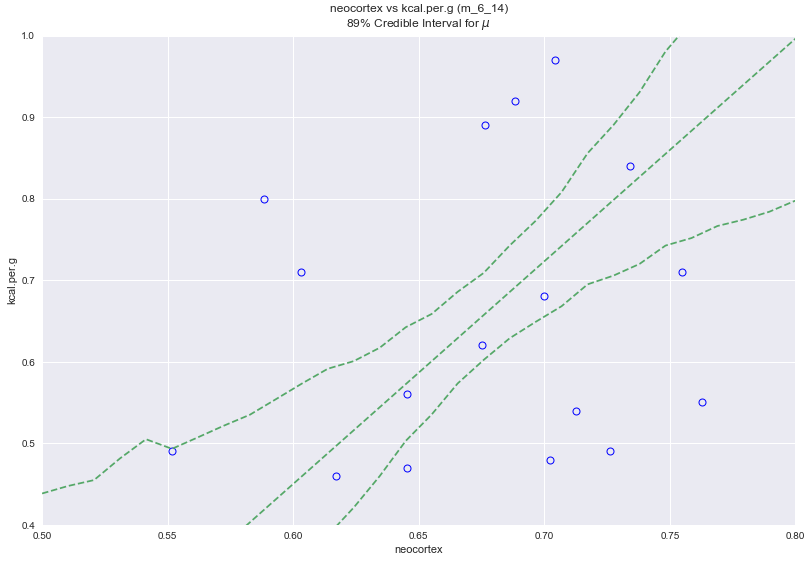

In [32]:
nc_seq = np.linspace(0.5, 0.8, 30)
mass = np.repeat(4.5, 30)

model_neocortex.set_value(nc_seq)
model_logmass.set_value(np.log(mass))
post_pred = pm.sample_ppc(trace6_14, samples=10000, model=m6_14, vars=[m6_14.mu])["mu"]

mu = post_pred.mean(axis=0)
mu_pi = pm.hpd(post_pred, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["neocortex"], d["kcal.per.g"], "o", mew=1, mec="b", mfc="None")
ax.plot(nc_seq, mu, "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 0], "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 1], "--", color="C1")
ax.set_xlim((0.5, 0.8))
ax.set_ylim((0.4, 1.0))
ax.set_title("neocortex vs kcal.per.g (m_6_14)\n"
             "89% Credible Interval for $\mu$")
ax.set_xlabel("neocortex")
ax.set_ylabel("kcal.per.g");

### 6.30

`pm.sample_ppc_w` does work for weighted predictions but since it doesn't have a `vars` parameter it can't be used in this situation.

In [33]:
models = {"m6_11": {"trace": trace6_11,
                    "model": m6_11,
                    "weight": milk_models.loc["m6_11"]["weight"]},
          "m6_12": {"trace": trace6_12,
                    "model": m6_12,
                    "weight": milk_models.loc["m6_12"]["weight"]},
          "m6_13": {"trace": trace6_13,
                     "model": m6_13,
                     "weight": milk_models.loc["m6_13"]["weight"]},
          "m6_14": {"trace": trace6_14,
                     "model": m6_14,
                     "weight": milk_models.loc["m6_14"]["weight"]}}

In [34]:
num_samples = 10000

acc = []
for (_, mdata) in models.items():
    pred = pm.sample_ppc(mdata["trace"], 
                         samples=int(mdata["weight"]*num_samples),
                         model=mdata["model"],
                         vars=[mdata["model"].mu])
    acc.append(pred["mu"])
wmu_pred = np.vstack(acc)

100%|██████████| 9600/9600 [00:01<00:00, 5245.35it/s]


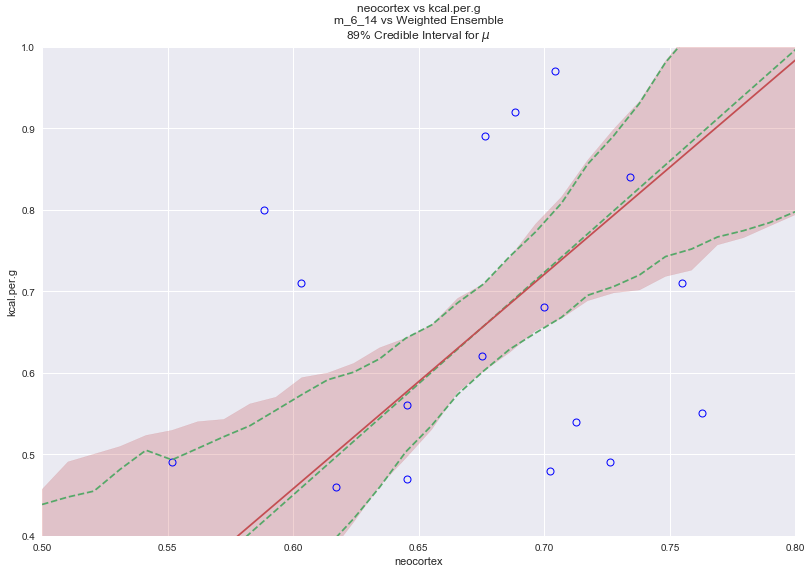

In [35]:
mu = post_pred.mean(axis=0)
mu_pi = pm.hpd(post_pred, alpha=0.11)
wmu = wmu_pred.mean(axis=0)
wmu_pi = pm.hpd(wmu_pred, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["neocortex"], d["kcal.per.g"], "o", mew=1, mec="b", mfc="None")

ax.plot(nc_seq, mu, "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 0], "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 1], "--", color="C1")

ax.plot(nc_seq, wmu, color="C2")
ax.fill_between(nc_seq, wmu_pi[:,0], wmu_pi[:,1], alpha=0.25, color="C2")

ax.set_xlim((0.5, 0.8))
ax.set_ylim((0.4, 1.0))
ax.set_title("neocortex vs kcal.per.g\n"
             "m_6_14 vs Weighted Ensemble\n"
             "89% Credible Interval for $\mu$")
ax.set_xlabel("neocortex")
ax.set_ylabel("kcal.per.g");

## Practice

### Easy

#### 6E1.

1. __The Measure of Uncertainty should be Continuous__

This prevents small changes in probabilities causing a large change in uncertainty.

2. __The Measure of Uncertainty should increase with the number of possible events__ 

Choosing from 3 equally likely events should have higher uncertainty than choosing from 2 equally likely events.

3. __The Measure of Uncertainty should be additive__

If we have the uncertainty over two events `A` and `B`, and the uncertainty over two other events `C` and `D`, then the joint uncertainty over all 4 combinations should be the sum of the two uncertainties.

#### 6E2.

I'm choosing log2 since I prefer the explanation of average number of bits needed to uniquely identify the state of the system

In [36]:
def entropy(ps, log=np.log2):
    "Given a list of probabilities, returns the entropy of the system"
    return -np.sum(ps * log(ps))

In [37]:
entropy(np.array([0.7, 0.3]))

0.8812908992306927

#### 6E4.

In [38]:
entropy(np.array([0.20, 0.25, 0.25, 0.30]))

1.9854752972273344

#### 6E5.

Events that have 0 probability of occuring don't need to be included

In [39]:
entropy(np.array([1.0/3, 1.0/3, 1.0/3]))

1.584962500721156

### Medium

#### 6M1.

##### AIC

This is computed as $D_{train} + 2p$ where $D_{train}$ is the in sample deviance and $p$ is the number of free paramaters in the model.

The assumptions made here

* The priors are flat or overwhelmed by the likelihood
* The posterior distribution is approximately multivariate Gaussian
* The sample size is much greater than the number of paramters.

##### DIC

This is computed as $\bar{D} + (\bar{D} - \hat{D})$ where $\bar{D}$ is the average deviance calculated for sampled parameters and $\hat{D}$ is the deviance calculated at the posterior mean.

$\bar{D} - \hat{D}$ is the effective number of parameters.

The assumptions made here are similar to AIC but relaxes the constraint for flat priors

* The posterior distribution is approximated multivariate Gaussian
* The sample size is much greater than the number of parameters


##### WAIC

This is computed  as $-2(lppd - p_{WAIC})$ where each term is a little involved.

$$lppd = \sum_{i=1}^{N} logPr(y_i)$$ 

Where $Pr(y_i)$ is the average likelihood of of observation $i$ in the training sample, i.e. the average likelihood for observation $y_i$ for each set of parameters sampled from the posterior.

The $log$ of this value is then summed across all observations.

$$p_{WAIC} = \sum_{i=1}^{N} V(y_i)$$

Where $V(y_i)$ is the variance in log-likelihood for observation $i$ in the training sample.

This is then summed across all observations.

WAIC doesn't assume a posterior distribution of a particular shape, it probably gets more accurate the more posterior samples taken.

#### 6M2.

_Model Selection_ chooses a single model to use when compared to a set of models, while _Model Averaging_ averages the predictions made by different models weighted by some information criteria (like WAIC).

With _Model Selection_ we lose information about the data that other models might have captured, effectively overfitting to a single model's view of the world.

With _Model Averaging_ we could be adding noise to our predictions by using predictions from models that aren't particularly reflective of the world.

#### 6M3.

WAIC, as an example of an information criteria, scales with the number of observations in the training data. Using different sizes of training data for each model would make comparing WAIC across models meaningless.

#### 6M4.

_should this be "posterior" becomes more concentrated?_

Looking at WAIC, as the posterior for each parameter becomes more concentrated, the variance of the log-likelihood for an observation becomes smaller since the variance in sampled parameters also becomes smaller. 

This implies that for more concentrated posteriors, the effective number of parameters (or model flexibility) reduces.

#### 6M5.

Informative priors can prevent a model from making too strong an assumption (overfitting) of what the underlying parameters of a model could look like, especially if the sample is non representative of the entire distribution.

#### 6M6.

Overly informative priors can prevent the model from learning from the dataset, effectively keeping the same posterior as the passed prior but I'm not sure why this could be considered underfitting.

### Hard

### 6.31

In [40]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d["age"] = (d["age"] - d["age"].mean())/d["age"].std()
np.random.seed(1000)
idxs = np.arange(len(d))
np.random.shuffle(idxs)
d1 = d[:int(len(idxs)/2)]
d2 = d[int(len(idxs)/2):]

In [41]:
model_age = theano.shared(d1["age"].values)

with pm.Model() as m6h_1:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_1 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6h_2:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=10)
    b2 = pm.Normal("b2", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age +\
                                b2*model_age*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_2 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6h_3:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=10)
    b2 = pm.Normal("b2", mu=0, sd=10)
    b3 = pm.Normal("b3", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age +\
                                b2*model_age*model_age +\
                                b3*model_age*model_age*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_3 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6h_4:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=10)
    b2 = pm.Normal("b2", mu=0, sd=10)
    b3 = pm.Normal("b3", mu=0, sd=10)
    b4 = pm.Normal("b4", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age +\
                                b2*model_age*model_age +\
                                b3*model_age*model_age*model_age +\
                                b4*model_age*model_age*model_age*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_4 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6h_5:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=10)
    b2 = pm.Normal("b2", mu=0, sd=10)
    b3 = pm.Normal("b3", mu=0, sd=10)
    b4 = pm.Normal("b4", mu=0, sd=10)
    b5 = pm.Normal("b5", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age +\
                                b2*model_age*model_age +\
                                b3*model_age*model_age*model_age +\
                                b4*model_age*model_age*model_age*model_age +\
                                b5*model_age*model_age*model_age*model_age*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_5 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6h_6:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=10)
    b2 = pm.Normal("b2", mu=0, sd=10)
    b3 = pm.Normal("b3", mu=0, sd=10)
    b4 = pm.Normal("b4", mu=0, sd=10)
    b5 = pm.Normal("b5", mu=0, sd=10)
    b6 = pm.Normal("b6", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age +\
                                b2*model_age*model_age +\
                                b3*model_age*model_age*model_age +\
                                b4*model_age*model_age*model_age*model_age +\
                                b5*model_age*model_age*model_age*model_age*model_age +\
                                b6*model_age*model_age*model_age*model_age*model_age*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_6 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 825.64draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b2, b1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 617.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b3, b2, b1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 499.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b4, b3, b2, b1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 281.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jo

#### 6h1.

In [42]:
height_models = [("m6h_1", m6h_1, trace6h_1),
                 ("m6h_2", m6h_2, trace6h_2),
                 ("m6h_3", m6h_3, trace6h_3),
                 ("m6h_4", m6h_4, trace6h_4),
                 ("m6h_5", m6h_5, trace6h_5),
                 ("m6h_6", m6h_6, trace6h_6)]

In [43]:
model_comparison = (pm.compare({row[1]:row[2] for row in height_models},
                               method="pseudo-BMA")
                    .join(pd.Series([row[0] for row in height_models], name="model"))
                    .set_index("model")
                    .sort_values("WAIC"))
                    
model_comparison

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6h_4,1924.16,5.73,0,0.52,23.59,0,1
m6h_6,1925.52,7.8,1.35,0.26,23.09,3.31,1
m6h_5,1925.86,6.5,1.7,0.22,23.57,0.55,1
m6h_3,1938.15,5.27,13.99,0,24.18,8.6,1
m6h_2,2058.92,4.74,134.75,0,23.82,19,1
m6h_1,2282.52,3.23,358.35,0,22.94,25.09,0


#### 6H2.

In [44]:
age_seq = np.linspace(-3, 3, 30)
model_age.set_value(age_seq)

acc = []
for row in height_models:
    samples = pm.sample_ppc(row[2], samples=10000, model=row[1], vars=[row[1].mu])["mu"]    
    acc.append((row[0], samples))
    
mu_preds = [acc[:3], acc[3:]]

100%|██████████| 10000/10000 [00:02<00:00, 3731.62it/s]


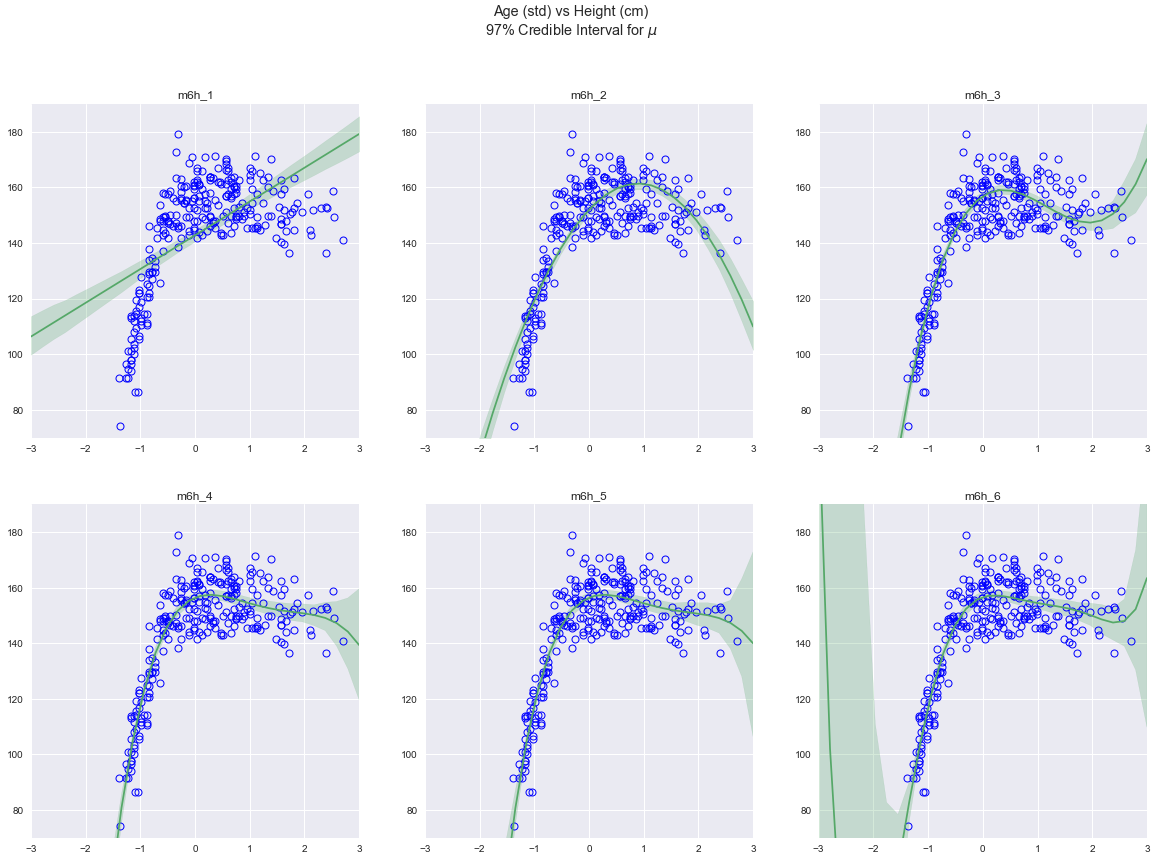

In [45]:
f, axs = plt.subplots(2, 3)
f.set_size_inches(20, 13.5)

for row in range(2):
    for col in range(3):
        model = mu_preds[row][col][0]
        pred = mu_preds[row][col][1]
        ax = axs[row][col]
        mu = pred.mean(axis=0)
        mu_pi = pm.hpd(pred, alpha=0.03)
        ax.set_xlim(-3, 3)
        ax.set_ylim(70, 190)
        ax.set_title(model)
        ax.plot(d1["age"], d1["height"], "o", mew=1, mec="b", mfc="None")
        ax.plot(age_seq, mu, color="C1")
        ax.fill_between(age_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25, color="C1")

f.suptitle("Age (std) vs Height (cm)\n"
           "97% Credible Interval for $\mu$");

#### 6H3

In [46]:
num_samples = 10000

acc = []
for row in height_models:
    weight = model_comparison.loc[row[0]]["weight"]
    pred = pm.sample_ppc(row[2],
                         samples=int(weight*num_samples),
                         model=row[1],
                         vars=[row[1].mu])
    acc.append(pred["mu"])
    
weighted_pred = np.vstack(acc)
lowest_pred = pm.sample_ppc(height_models[3][2],
                            samples=num_samples,
                            model=height_models[3][1],
                            vars=[height_models[3][1].mu])["mu"]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 10000/10000 [00:02<00:00, 4168.06it/s]


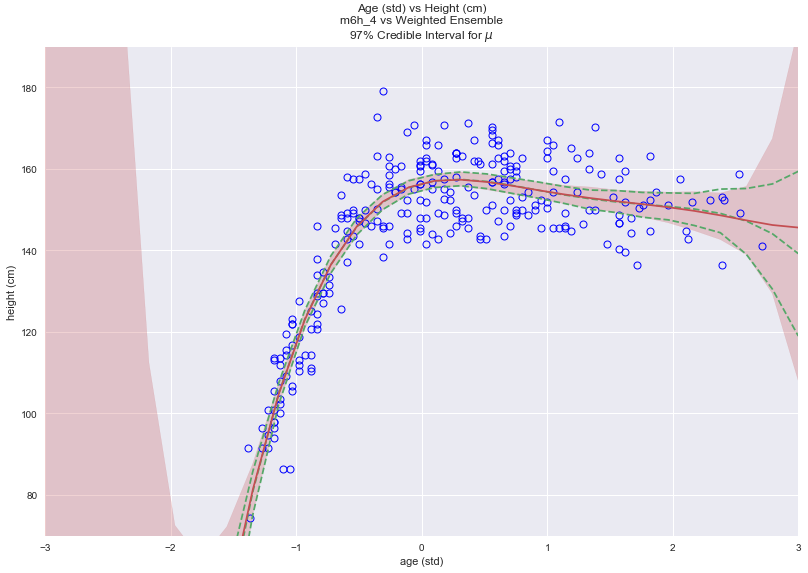

In [47]:
mu = lowest_pred.mean(axis=0)
mu_pi = pm.hpd(lowest_pred, alpha=0.03)
wmu = weighted_pred.mean(axis=0)
wmu_pi = pm.hpd(weighted_pred, alpha=0.03)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d1["age"], d1["height"], "o", mew=1, mec="b", mfc="None")

ax.plot(age_seq, mu, "--", color="C1")
ax.plot(age_seq, mu_pi[:, 0], "--", color="C1")
ax.plot(age_seq, mu_pi[:, 1], "--", color="C1")

ax.plot(age_seq, wmu, color="C2")
ax.fill_between(age_seq, wmu_pi[:,0], wmu_pi[:,1], alpha=0.25, color="C2")

ax.set_xlim((-3, 3))
ax.set_ylim((70, 190))
ax.set_title("Age (std) vs Height (cm)\n"
             "m6h_4 vs Weighted Ensemble\n"
             "97% Credible Interval for $\mu$")
ax.set_xlabel("age (std)")
ax.set_ylabel("height (cm)");

The average predictions mostly follow the predictions of the model with the lowest WAIC, with any deviation happening near the extremes of the observations.

The credible bounds are also larger for the average predictions which is the expected result.

#### 6H4.

In [48]:
model_age.set_value(d2["age"])
test_samples = []
for row in height_models:
    samples = pm.sample_ppc(row[2], samples=10000, model=row[1], vars=[row[1].mu, row[1].sigma])    
    test_samples.append((samples["mu"].mean(0), samples["sigma"].mean()))

100%|██████████| 10000/10000 [00:03<00:00, 3149.00it/s]


In [49]:
acc = []
for (row, samples) in zip(height_models, test_samples):
    deviance = -2 * np.sum(stats.norm.logpdf(d2["height"], loc=samples[0], scale=samples[1]))
    acc.append(deviance)
    
test_dev = (pd.DataFrame(acc, columns=["test_deviance"])
            .join(pd.Series([row[0] for row in height_models], name="model"))
            .set_index("model"))
test_dev

,test_deviance
model,
m6h_1,2737.523903
m6h_2,2384.841126
m6h_3,1999.093942
m6h_4,1897.252660
m6h_5,1897.150535
m6h_6,1916.276142


#### 6H5.

In [50]:
(test_dev
 .assign(dTestDeviance=lambda df: df["test_deviance"] - df["test_deviance"].min())
 .join(model_comparison[["WAIC", "dWAIC", "weight"]])
 .assign(scaled_test_weight=lambda df: np.exp(-0.5*df["dTestDeviance"]))
 .assign(test_weight=lambda df: np.round(df["scaled_test_weight"]/np.sum(df["scaled_test_weight"]), 2))
 [["WAIC", "test_deviance", "dWAIC", "dTestDeviance", "weight", "test_weight"]])

,WAIC,test_deviance,dWAIC,dTestDeviance,weight,test_weight
model,,,,,,
m6h_1,2282.52,2737.523903,358.35,840.373367,0,0.00
m6h_2,2058.92,2384.841126,134.75,487.690591,0,0.00
m6h_3,1938.15,1999.093942,13.99,101.943406,0,0.00
m6h_4,1924.16,1897.252660,0,0.102125,0.52,0.49
m6h_5,1925.86,1897.150535,1.7,0.000000,0.22,0.51
m6h_6,1925.52,1916.276142,1.35,19.125607,0.26,0.00


At least for model ordering, WAIC follows actual test deviance quite closely, the main difference here is that `m6h_5` is preferred over `m6h_4`, however the actual WAIC and test deviance differences for these models is small.

In model weight, no weight is given to `m6h_6` which could be because of overfitting.

#### 6H6.

In [51]:
model_age.set_value(d1["age"])

with pm.Model() as m6h_7:
    a = pm.Normal("a", mu=np.mean(d1["height"]), sd=10)
    b1 = pm.Normal("b1", mu=0, sd=5)
    b2 = pm.Normal("b2", mu=0, sd=5)
    b3 = pm.Normal("b3", mu=0, sd=5)
    b4 = pm.Normal("b4", mu=0, sd=5)
    b5 = pm.Normal("b5", mu=0, sd=5)
    b6 = pm.Normal("b6", mu=0, sd=5)
    sigma = pm.Uniform("sigma", 0,  np.std(d1["height"]) * 10)
    mu = pm.Deterministic("mu", a +\
                                b1*model_age +\
                                b2*model_age*model_age +\
                                b3*model_age*model_age*model_age +\
                                b4*model_age*model_age*model_age*model_age +\
                                b5*model_age*model_age*model_age*model_age*model_age +\
                                b6*model_age*model_age*model_age*model_age*model_age*model_age)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d1["height"])
    trace6h_7 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:21<00:00, 49.11draws/s]


In [52]:
age_seq = np.linspace(-3, 3, 30)
model_age.set_value(age_seq)
pred = pm.sample_ppc(trace6h_7, samples=10000, model=m6h_7, vars=[m6h_7.mu])["mu"]

100%|██████████| 10000/10000 [00:02<00:00, 3598.75it/s]


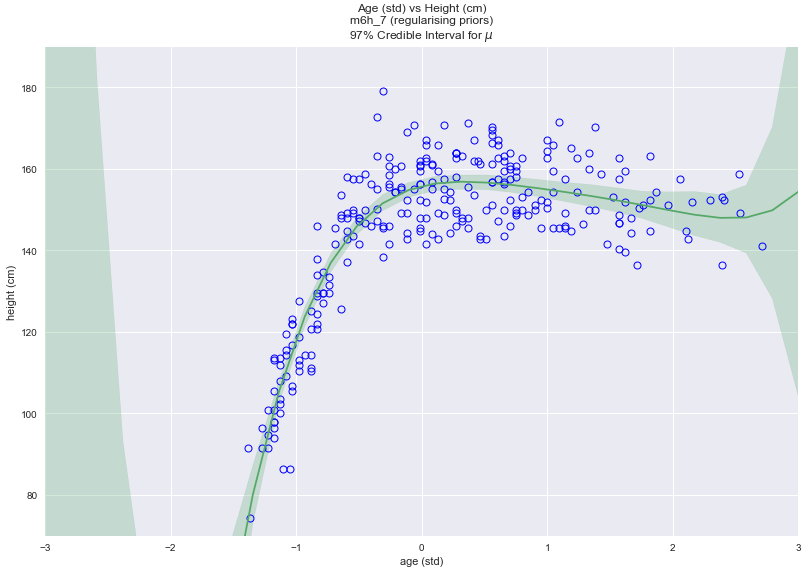

In [53]:
mu = pred.mean(axis=0)
mu_pi = pm.hpd(pred, alpha=0.03)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d1["age"], d1["height"], "o", mew=1, mec="b", mfc="None")

ax.plot(age_seq, mu, color="C1")
ax.fill_between(age_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25, color="C1")

ax.set_xlim((-3, 3))
ax.set_ylim((70, 190))
ax.set_title("Age (std) vs Height (cm)\n"
             "m6h_7 (regularising priors)\n"
             "97% Credible Interval for $\mu$")
ax.set_xlabel("age (std)")
ax.set_ylabel("height (cm)");

In [54]:
model_age.set_value(d2["age"])
samples = pm.sample_ppc(trace6h_7, samples=10000, model=m6h_7, vars=[m6h_7.mu, m6h_7.sigma])    

100%|██████████| 10000/10000 [00:03<00:00, 2752.10it/s]


In [55]:
deviance = -2 * np.sum(stats.norm.logpdf(d2["height"], loc=samples["mu"].mean(0), scale=samples["sigma"].mean()))
deviance

1891.7912862487585

This model has the lowest out of sample deviance compared to any of the models trained earlier, I take this to mean that the models with the best performance earlier were overfitting since introducing regularising priors in this model led to an increase in performance.